## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras
from keras.datasets import cifar10
import warnings
warnings.filterwarnings('ignore')

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
train, test = keras.datasets.cifar10.load_data()

# 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [3]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [4]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [5]:
# 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 30
BATCH_SIZE = 1024

In [6]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.Adam, keras.optimizers.RMSprop]
reduce_lr_factor = [0.5, 0.8]
redice_lr_patient = [5, 10]

In [7]:
import itertools
results = {}
for optim, reduce_factor, reduce_patient in itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print(f"Optimizer: {optim}, Factor: {reduce_factor}, Patience: {reduce_patient}")
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = optim(lr=1e-3)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=reduce_patient, 
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = (f"Optimizer: {optim}, Factor: {reduce_factor}, Patience: {reduce_patient}")
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Optimizer: <class 'keras.optimizers.optimizer_v2.adam.Adam'>, Factor: 0.5, Patience: 5
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                        

 hNormalization)                                                 
                                                                 
 output (Dense)              (None, 10)                1290      
                                                                 
Total params: 1,742,474
Trainable params: 1,740,682
Non-trainable params: 1,792
_________________________________________________________________
Epoch 1/30
49/49 [==============================] - 7s 109ms/step - loss: 1.7633 - accuracy: 0.3865 - val_loss: 2.5932 - val_accuracy: 0.2101 - lr: 0.0010
Epoch 2/30
49/49 [==============================] - 5s 93ms/step - loss: 1.4925 - accuracy: 0.4707 - val_loss: 1.8553 - val_accuracy: 0.3568 - lr: 0.0010
Epoch 3/30
49/49 [==============================] - 4s 90ms/step - loss: 1.3878 - accuracy: 0.5119 - val_loss: 1.8456 - val_accuracy: 0.3679 - lr: 0.0010
Epoch 4/30
49/49 [==============================] - 4s 91ms/step - loss: 1.3104 - accuracy: 0.5396 - val_loss: 1.7500 - val_acc

Epoch 8/30
49/49 [==============================] - 6s 127ms/step - loss: 1.0753 - accuracy: 0.6240 - val_loss: 1.7781 - val_accuracy: 0.3789 - lr: 8.0000e-04
Epoch 9/30
49/49 [==============================] - 4s 86ms/step - loss: 1.0260 - accuracy: 0.6405 - val_loss: 1.8659 - val_accuracy: 0.3814 - lr: 8.0000e-04
Epoch 10/30
49/49 [==============================] - 3s 60ms/step - loss: 0.9873 - accuracy: 0.6553 - val_loss: 1.6801 - val_accuracy: 0.4193 - lr: 8.0000e-04
Epoch 11/30
49/49 [==============================] - 3s 61ms/step - loss: 0.9424 - accuracy: 0.6721 - val_loss: 1.6368 - val_accuracy: 0.4271 - lr: 8.0000e-04
Epoch 12/30
49/49 [==============================] - 3s 61ms/step - loss: 0.9048 - accuracy: 0.6853 - val_loss: 1.7622 - val_accuracy: 0.3987 - lr: 8.0000e-04
Epoch 13/30
49/49 [==============================] - 3s 62ms/step - loss: 0.8664 - accuracy: 0.6974 - val_loss: 1.8832 - val_accuracy: 0.3975 - lr: 8.0000e-04
Epoch 14/30
49/49 [============================

Epoch 15/30
49/49 [==============================] - 6s 130ms/step - loss: 0.7771 - accuracy: 0.7322 - val_loss: 1.8878 - val_accuracy: 0.4163 - lr: 8.0000e-04
Epoch 16/30
49/49 [==============================] - 5s 111ms/step - loss: 0.7447 - accuracy: 0.7436 - val_loss: 1.8791 - val_accuracy: 0.4203 - lr: 8.0000e-04
Epoch 17/30
49/49 [==============================] - 5s 104ms/step - loss: 0.7088 - accuracy: 0.7570 - val_loss: 1.6581 - val_accuracy: 0.4569 - lr: 8.0000e-04
Epoch 18/30
49/49 [==============================] - 5s 108ms/step - loss: 0.6711 - accuracy: 0.7688 - val_loss: 1.7729 - val_accuracy: 0.4434 - lr: 8.0000e-04
Epoch 19/30
49/49 [==============================] - 5s 112ms/step - loss: 0.6375 - accuracy: 0.7811 - val_loss: 1.9720 - val_accuracy: 0.4294 - lr: 8.0000e-04
Epoch 20/30
49/49 [==============================] - 5s 110ms/step - loss: 0.6126 - accuracy: 0.7895 - val_loss: 1.8267 - val_accuracy: 0.4622 - lr: 8.0000e-04
Epoch 21/30
49/49 [=====================

49/49 [==============================] - 4s 76ms/step - loss: 0.6020 - accuracy: 0.8040 - val_loss: 1.5165 - val_accuracy: 0.5041 - lr: 2.5000e-04
Epoch 23/30
49/49 [==============================] - 4s 78ms/step - loss: 0.5827 - accuracy: 0.8140 - val_loss: 1.5110 - val_accuracy: 0.5139 - lr: 2.5000e-04
Epoch 24/30
49/49 [==============================] - ETA: 0s - loss: 0.5637 - accuracy: 0.8205
Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
49/49 [==============================] - 4s 78ms/step - loss: 0.5637 - accuracy: 0.8205 - val_loss: 1.5236 - val_accuracy: 0.5160 - lr: 2.5000e-04
Epoch 25/30
49/49 [==============================] - 4s 83ms/step - loss: 0.5159 - accuracy: 0.8423 - val_loss: 1.4933 - val_accuracy: 0.5252 - lr: 1.2500e-04
Epoch 26/30
49/49 [==============================] - 4s 83ms/step - loss: 0.5035 - accuracy: 0.8465 - val_loss: 1.5195 - val_accuracy: 0.5199 - lr: 1.2500e-04
Epoch 27/30
49/49 [==============================] - 4s 8

Epoch 29/30
49/49 [==============================] - 6s 120ms/step - loss: 0.4307 - accuracy: 0.8693 - val_loss: 1.6398 - val_accuracy: 0.5222 - lr: 2.5000e-04
Epoch 30/30
49/49 [==============================] - 6s 119ms/step - loss: 0.4147 - accuracy: 0.8756 - val_loss: 1.6628 - val_accuracy: 0.5145 - lr: 2.5000e-04
Optimizer: <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>, Factor: 0.8, Patience: 5
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                            

 hNormalization)                                                 
                                                                 
 hidden_layer3 (Dense)       (None, 128)               32896     
                                                                 
 batch_normalization_2 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 output (Dense)              (None, 10)                1290      
                                                                 
Total params: 1,742,474
Trainable params: 1,740,682
Non-trainable params: 1,792
_________________________________________________________________
Epoch 1/30
49/49 [==============================] - 7s 86ms/step - loss: 1.8134 - accuracy: 0.3738 - val_loss: 2.5052 - val_accuracy: 0.1935 - lr: 0.0010
Epoch 2/30
49/49 [==============================] - 4s 82ms/step - loss: 1.5337 - accuracy: 0.4595 - val_l

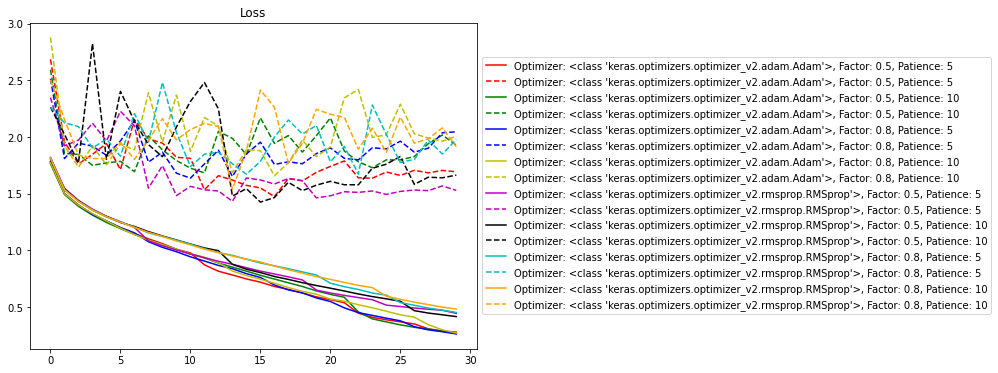

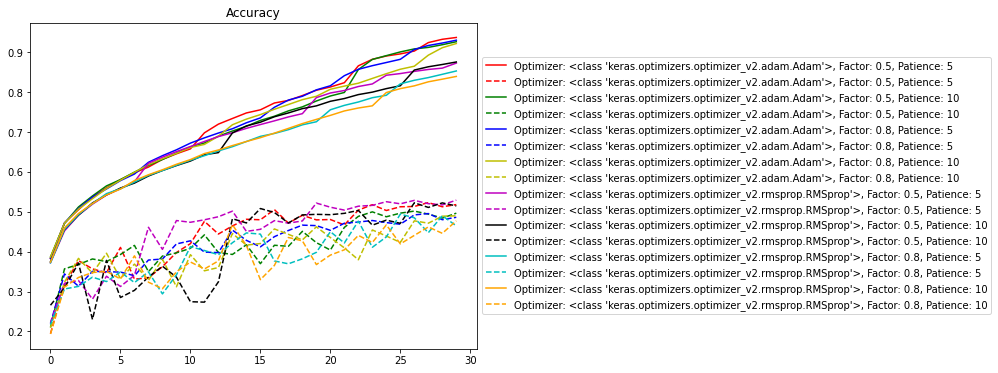

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k", "c", "orange"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### 筆記
1. Reduce Factor 小一點 (降低程度大一點), 效果會好一點
2. Patience 少一點, Reduce 的機會就會多一點 (若要 Patience 大一點, 或許 Epochs 大一點比較能看得出效果)
3. 使用 ReduceLROnPlateau 似乎會記錄目前的 Learning rate, 所以若沒有重新定義 Learning rate, 就會使用已經降低過後的值